Overview: Result
================

In this example, we'll repeat the fit of 1D data of a `Gaussian` profile with a 1D `Gaussian` model using the non-linear
search emcee and inspect the *Result* object that is returned in detail.

If you haven't already, you should checkout the notebook `overview/fit.ipynb` to  see how the fit is performed by the
code below. The first section of code below is simmply repeating the commands in `example/fit.py`, so feel free to
skip over it until you his the `Result`'s section.

In [1]:
%matplotlib inline

import autofit as af

from os import path
import matplotlib.pyplot as plt
import numpy as np

At the top of every tutorial notebook, you'll see the following cell. This cell uses the project `pyprojroot` to
locate the path to the workspace on your computer and use it to set the working directory of the notebook.

In [2]:
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


__Data__

First, lets load data of a 1D Gaussian, by loading it from a .json file in the directory 
`autofit_workspace/dataset/`, which  simulates the noisy data we fit (check it out to see how we simulate the 
data).

In [3]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")

data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

__Model + Analysis__

We create the same model and analysis classes use in the example `autofit_workspace/notebooks/overview/simple/fit.ipynb`.

In [4]:
class Gaussian:
    def __init__(
        self,
        centre=0.0,  # <- PyAutoFit recognises these constructor arguments
        intensity=0.1,  # <- are the Gaussian`s model parameters.
        sigma=0.01,
    ):
        """Represents a 1D `Gaussian` profile, which may be treated as a model-component of PyAutoFit the
        parameters of which are fitted for by a non-linear search.

        Parameters
        ----------
        centre : float
            The x coordinate of the profile centre.
        intensity : float
            Overall intensity normalisation of the `Gaussian` profile.
        sigma : float
            The sigma value controlling the size of the Gaussian.
        """

        self.centre = centre
        self.intensity = intensity
        self.sigma = sigma

    def profile_from_xvalues(self, xvalues):
        """
        Calculate the intensity of the profile on a line of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, using its centre.

        Parameters
        ----------
        xvalues : np.ndarray
            The x coordinates in the original reference frame of the grid.
        """

        transformed_xvalues = xvalues - self.centre

        return np.multiply(
            np.divide(self.intensity, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )

In [5]:
class Analysis(af.Analysis):

    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):
        """
        Determine the log likelihood of a fit of a `Gaussian` to the dataset, using a model instance of the Gaussian.

        Parameters
        ----------
        instance : model.Gaussian
            The `Gaussian` model instance.

        Returnsn
        -------
        fit : Fit.log_likelihood
            The log likelihood value indicating how well this model fit the dataset.
        """

        xvalues = np.arange(self.data.shape[0])
        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        log_likelihood = -0.5 * sum(chi_squared_map)

        return log_likelihood


In [6]:
model = af.PriorModel(Gaussian)
analysis = Analysis(data=data, noise_map=noise_map)

We now perform the fit to get a `Result` object.

In [7]:
emcee = af.Emcee(
    path_prefix=path.join("overview", "simple"),
    nwalkers=30,
    nsteps=1000,
    initializer=af.InitializerBall(lower_limit=0.49, upper_limit=0.51),
    auto_correlation_check_for_convergence=True,
    auto_correlation_check_size=100,
    auto_correlation_required_length=50,
    auto_correlation_change_threshold=0.01,
    number_of_cores=1,
)

result = emcee.fit(model=model, analysis=analysis)

INFO:root: already completed, skipping non-linear search.


__Result__

Here, we'll look in detail at what information is contained in the result.

It contains a `Samples` object, which contains information on the non-linear sampling, for example the parameters. 
The parameters are stored as a list of lists, where the first entry corresponds to the sample index and second entry
the parameter index.

In [8]:
samples = result.samples

print("Final 10 Parameters:")
print(samples.parameters[-10:])

print("\nSample 10`s third parameter value (Gaussian -> sigma)")
print(samples.parameters[9][2], "\n")

Final 10 Parameters:
[[49.81760940791169, 25.380801636474146, 10.113064132601512], [49.96772415736225, 25.1196190312827, 10.199594863761089], [50.03866941020159, 25.44147322971663, 10.389446642448489], [50.06533288426526, 25.05436395387136, 9.989428778730497], [49.94140762629154, 25.35855800100092, 10.203190745616782], [49.973765013025165, 25.505662195761783, 10.13612429889066], [50.112124120965106, 25.583576779167718, 10.247306980129702], [49.94597874084403, 25.35286700428, 9.961142913300327], [49.97163614603085, 25.79503873034016, 10.07556567931268], [50.01138824995274, 25.113691823543455, 9.959799316155438]]

Sample 10`s third parameter value (Gaussian -> sigma)
10.168967232724343 



The Samples class also contains the log likelihood, log prior, log posterior and weights of every accepted sample,
where:

   - The log likelihood is the value evaluated from the likelihood function (e.g. -0.5 * chi_squared + the noise
     normalized).

   - The log prior encodes information on how the priors on the parameters maps the log likelihood value to the log
     posterior value.

   - The log posterior is log_likelihood + log_prior.

   - The weight gives information on how samples should be combined to estimate the posterior. The weight values
     depend on the sampler used, for MCMC samples they are all 1 (e.g. all weighted equally).

Lets inspect the last 10 values of each for the analysis.

In [9]:
print("Final 10 Log Likelihoods:")
print(samples.log_likelihoods[-10:])

print("Final 10 Log Priors:")
print(samples.log_priors[-10:])

print("Final 10 Log Posteriors:")
print(samples.log_posteriors[-10:])

print("Final 10 Sample Weights:")
print(samples.weights[-10:], "\n")

Final 10 Log Likelihoods:
[-50.6270819017806, -51.43311063173146, -52.87664128274471, -50.90341306621794, -50.43203763301802, -50.10973079048656, -51.11636212530744, -50.82823117336086, -51.874299709975645, -50.69307625748373]
Final 10 Log Priors:
[0.039655528733727866, 0.040606283139537055, 0.04233927364330974, 0.03991544142589404, 0.04026014852501372, 0.03957757698129332, 0.04031079078167333, 0.039473468310823066, 0.03888134817652031, 0.03985123849008368]
Final 10 Log Posteriors:
[-50.587426373046874, -51.39250434859192, -52.8343020091014, -50.86349762479204, -50.391777484493005, -50.070153213505264, -51.076051334525765, -50.78875770505004, -51.83541836179913, -50.653225018993645]
Final 10 Sample Weights:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



The median pdf vector is readily available from the `Samples` object for you convenience (and if a nested sampling
`NonLinearSearch` is used instead, it will use an appropriate method to estimate the parameters):

In [10]:
median_pdf_vector = samples.median_pdf_vector
print("Median PDF Vector:")
print(median_pdf_vector, "\n")

Median PDF Vector:
[49.96194110514262, 25.34803868941411, 10.105398424036814] 



The samples contain many useful vectors, including the samples with the highest likelihood and posterior values:

In [11]:
max_log_likelihood_vector = samples.max_log_likelihood_vector
max_log_posterior_vector = samples.max_log_posterior_vector

print("Maximum Log Likelihood Vector:")
print(max_log_likelihood_vector)

print("\nMaximum Log Posterior Vector:")
print(max_log_posterior_vector)


Maximum Log Likelihood Vector:
[49.96625377393723, 25.386655215156036, 10.108701758622068]

Maximum Log Posterior Vector:
[49.96625377393723, 25.386655215156036, 10.108701758622068]


It also provides methods for computing the error estimates of all parameters at an input sigma confidence limit, which
can be returned at the values of the parameters including their errors or the size of the errors on each parameter:

In [12]:
vector_at_upper_sigma = samples.vector_at_upper_sigma(sigma=3.0)
vector_at_lower_sigma = samples.vector_at_lower_sigma(sigma=3.0)

print("Upper Parameter values w/ error (at 3.0 sigma confidence):")
print(vector_at_upper_sigma)

print("lower Parameter values w/ errors (at 3.0 sigma confidence):")
print(vector_at_lower_sigma, "\n")

error_vector_at_upper_sigma = samples.error_vector_at_upper_sigma(sigma=3.0)
error_vector_at_lower_sigma = samples.error_vector_at_lower_sigma(sigma=3.0)

print("Upper Error values (at 3.0 sigma confidence):")
print(error_vector_at_upper_sigma)

print("lower Error values (at 3.0 sigma confidence):")
print(error_vector_at_lower_sigma, "\n")

Upper Parameter values w/ error (at 3.0 sigma confidence):
[50.320222071180325, 26.206520409347487, 10.489729973810912]
lower Parameter values w/ errors (at 3.0 sigma confidence):
[49.62512825499476, 24.607446268766772, 9.804260518184657] 

Upper Error values (at 3.0 sigma confidence):
[0.35828096603770376, 0.8584817199333763, 0.3843315497740978]
lower Error values (at 3.0 sigma confidence):
[0.336812850147858, 0.7405924206473387, 0.3011379058521566] 



Results vectors return the results as a list, which means you need to know the parameter ordering. The list of
parameter names are available as a property of the `Samples`, as are parameter labels which can be used for labeling
figures:

In [13]:
print(samples.model.model_component_and_parameter_names)
print("\n")
print(samples.model.parameter_labels)
print("\n")

['centre', 'intensity', 'sigma']


['x', 'I', 'sigma']




Results can instead be returned as an instance, which is an instance of the model using the Python classes used to
compose it:

In [14]:
max_log_likelihood_instance = samples.max_log_likelihood_instance

print("Max Log Likelihood `Gaussian` Instance:")
print("Centre = ", max_log_likelihood_instance.centre)
print("Intensity = ", max_log_likelihood_instance.intensity)
print("Sigma = ", max_log_likelihood_instance.sigma, "\n")

Max Log Likelihood `Gaussian` Instance:
Centre =  49.96625377393723
Intensity =  25.386655215156036
Sigma =  10.108701758622068 



For our example problem of fitting a 1D `Gaussian` profile, this makes it straight forward to plot the maximum
likelihood model:

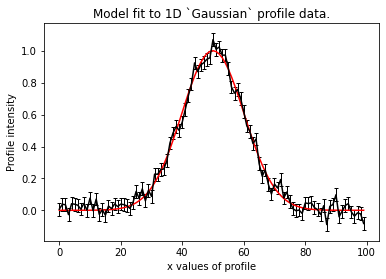

In [15]:
model_data = samples.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)

xvalues = range(data.shape[0])
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Model fit to 1D `Gaussian` profile data.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()


All methods above are available as an instance:

In [16]:
median_pdf_instance = samples.median_pdf_instance
instance_at_upper_sigma = samples.instance_at_upper_sigma
instance_at_lower_sigma = samples.instance_at_lower_sigma
error_instance_at_upper_sigma = samples.error_instance_at_upper_sigma
error_instance_at_lower_sigma = samples.error_instance_at_lower_sigma

An instance of any accepted sample can be created:

In [17]:
instance = samples.instance_from_sample_index(sample_index=500)
print("Gaussian Instance of sample 5000:")
print("Centre = ", instance.centre)
print("Intensity = ", instance.intensity)
print("Sigma = ", instance.sigma, "\n")

Gaussian Instance of sample 5000:
Centre =  55.445356660510434
Intensity =  1.4474216513748008
Sigma =  9.941517619578546 



If a nested sampling `NonLinearSearch` is used, the evidence of the model is also available which enables Bayesian
model comparison to be performed (given we are using Emcee, which is not a nested sampling algorithm, the log evidence 
is None).:

In [18]:
print(samples.log_evidence)

None


At this point, you might be wondering what else the results contains - pretty much everything we discussed above was a
part of its *samples* property! For projects which use **PyAutoFit**'s phase API (see the howtofit tutrials), the 
`Result`'s object can be extended to include model-specific results.

For example, we may extend the results of our 1D `Gaussian` example to include properties containing the maximum
log likelihood of the summed model data and for every individual profile in the model.

(The commented out functions below are llustrative of the API we can create, but do not work in this example given we 
are not using the phase API.)

In [19]:
# max_log_likelihood_profile = results.max_log_likelihood_profile
# max_log_likelihood_profile_list = results.max_log_likelihood_profile_list
